In [ ]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Datasets/데이콘/HD/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Datasets/데이콘/HD/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/Datasets/데이콘/HD/sample_submission.csv")

train.drop(['SAMPLE_ID'],1,inplace=True)
test.drop(['SAMPLE_ID'],1,inplace=True)

In [ ]:
train.shape, test.shape

((391939, 22), (220491, 21))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [ ]:
train.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [ ]:
for _ in train.columns:
  print(f"{_} has {(train[_].isna().sum()/train.shape[0]) * 100} Null.")

ARI_CO has 0.0 Null.
ARI_PO has 0.0 Null.
SHIP_TYPE_CATEGORY has 0.0 Null.
DIST has 0.0 Null.
ATA has 0.0 Null.
ID has 0.0 Null.
BREADTH has 0.0002551417439958769 Null.
BUILT has 0.0 Null.
DEADWEIGHT has 0.0 Null.
DEPTH has 0.0002551417439958769 Null.
DRAUGHT has 0.0002551417439958769 Null.
GT has 0.0 Null.
LENGTH has 0.0002551417439958769 Null.
SHIPMANAGER has 0.0 Null.
FLAG has 0.0 Null.
U_WIND has 41.763641791197095 Null.
V_WIND has 41.763641791197095 Null.
AIR_TEMPERATURE has 42.003985314041216 Null.
BN has 41.763641791197095 Null.
ATA_LT has 0.0 Null.
PORT_SIZE has 0.0 Null.
CI_HOUR has 0.0 Null.


In [ ]:
train.select_dtypes(include='object').columns.tolist()

['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ATA', 'ID', 'SHIPMANAGER', 'FLAG']

In [ ]:
for cat in ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ATA', 'ID', 'SHIPMANAGER', 'FLAG']:
  print(f"{cat} : {train[cat].nunique()}")

ARI_CO : 25
ARI_PO : 103
SHIP_TYPE_CATEGORY : 4
ATA : 336609
ID : 25028
SHIPMANAGER : 6566
FLAG : 125


# EDA

In [ ]:
import sweetviz as sv

sweet_report = sv.analyze(train)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
num_cols = train.select_dtypes(exclude='object').columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()

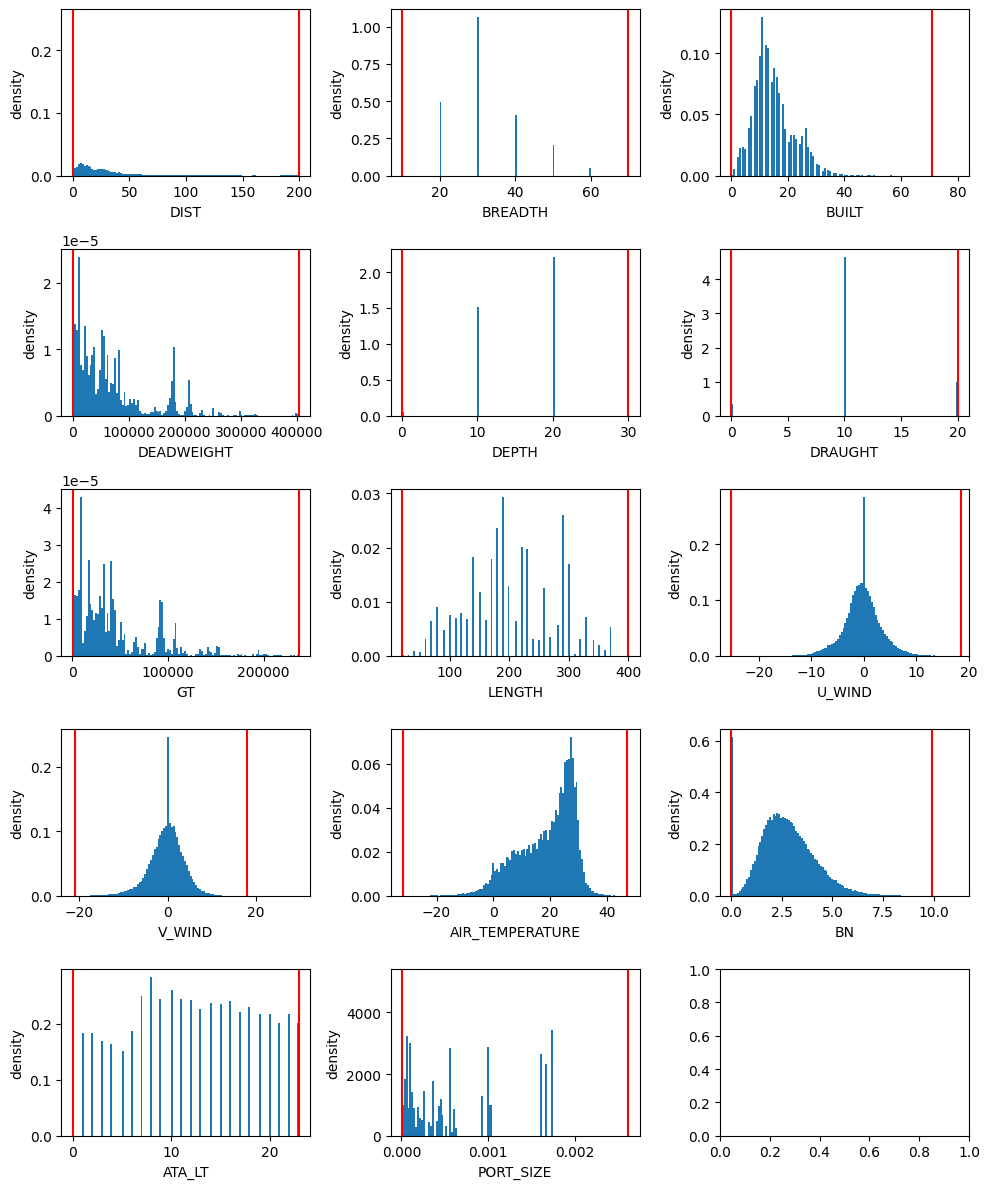

In [ ]:
f, ax = plt.subplots(5,3, figsize=(10,12))
ax = ax.ravel()
for ax, f in zip(ax, ['DIST',
 'BREADTH',
 'BUILT',
 'DEADWEIGHT',
 'DEPTH',
 'DRAUGHT',
 'GT',
 'LENGTH',
 'U_WIND',
 'V_WIND',
 'AIR_TEMPERATURE',
 'BN',
 'ATA_LT',
 'PORT_SIZE']):
  ax.hist(train[f], bins=120, density=True)
  ax.set_xlabel(f)
  ax.set_ylabel('density')
  ax.axvline(test[f].min(), color='r')
  ax.axvline(test[f].max(), color='r')
plt.tight_layout()
plt.show()

**Insight**
- 전체적으로 TEST SET과 TRAIN SET은 유사함.
- 빨간선(test set min, max)를 기준으로 이상치를 판단할 수 있음.


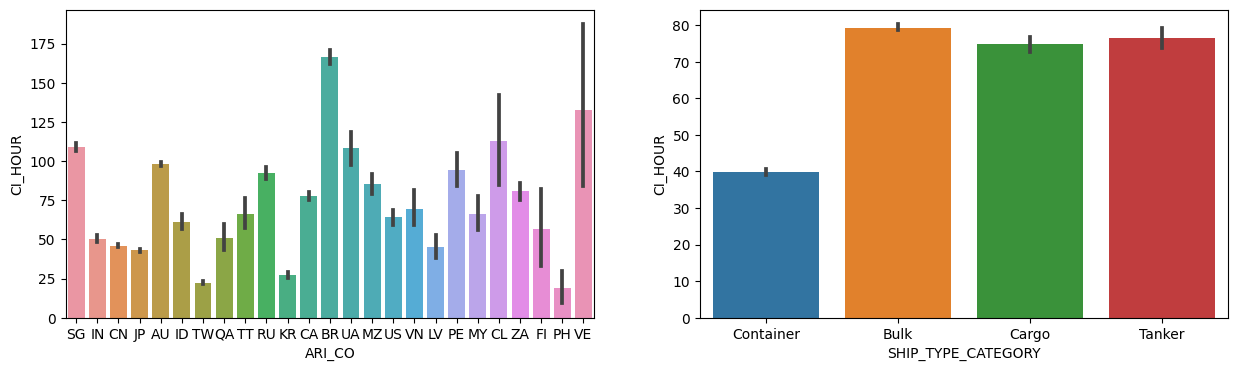

In [ ]:
plt.figure(figsize=(15,4))
for i, _ in enumerate(['ARI_CO','SHIP_TYPE_CATEGORY']):
  plt.subplot(1,2,i+1)
  sns.barplot(x=train[_], y=train['CI_HOUR'])
plt.show()

In [ ]:
train['CI_HOUR'].mean()

61.9408345927027

**Insight**

-  ARI_CO (도착항의 소속국가)가 남미국가(BR, VE, CL)인 경우 평균 대기시간인 61.8보다 훨씬 길다.
- 컨테이너의 경우 대기시간이 짧다.

<Figure size 640x480 with 0 Axes>

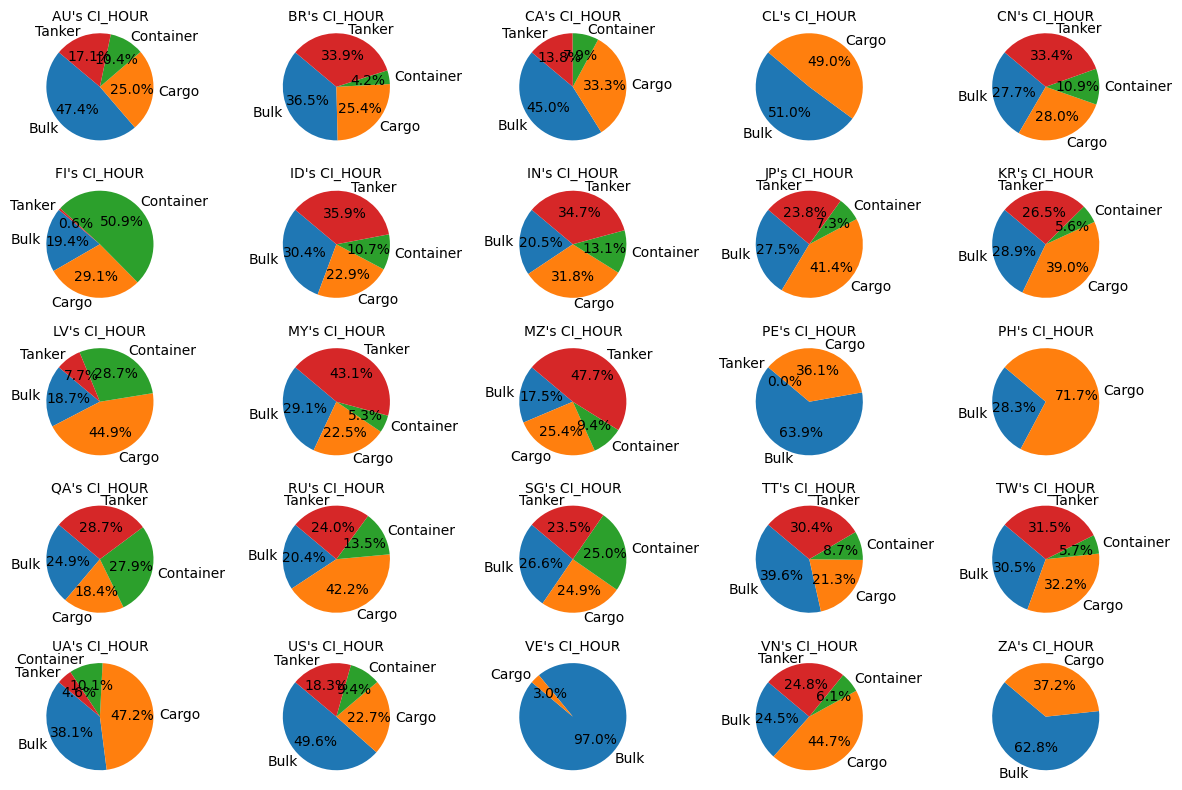

In [ ]:
result = train.groupby(['ARI_CO', 'SHIP_TYPE_CATEGORY'])['CI_HOUR'].mean().reset_index()

# ARI_CO 값의 고유한 리스트 가져오기
ari_CO_values = result['ARI_CO'].unique()

i = 0
plt.figure()
plt.subplots(5,5,figsize=(12,8))

# ARI_CO 값 별로 파이 차트 그리기
for ari_CO in ari_CO_values:
  i += 1
  plt.subplot(5,5,i)
  df_filtered = result[result['ARI_CO'] == ari_CO]
  plt.pie(df_filtered['CI_HOUR'], labels=df_filtered['SHIP_TYPE_CATEGORY'], autopct='%1.1f%%', startangle=140)
  plt.title(f"{ari_CO}'s CI_HOUR", fontsize=10)
  plt.axis('equal')  # 원형 파이 차트로 설정
plt.tight_layout()

# preprocessing

In [ ]:
import datetime
#ATA
def transform_time(df):
  df.drop(['ID','SHIPMANAGER'],1, inplace=True)

  df['ATA'] = pd.to_datetime(df['ATA'])
  df['YEAR'] = df['ATA'].dt.year
  df['MONTH'] = df['ATA'].dt.month
  df['DAY'] = df['ATA'].dt.day
  df['HOUR'] = df['ATA'].dt.hour
  df['MINUTES'] = df['ATA'].dt.minute
  df['WOY'] = df['ATA'].dt.weekofyear
  df['WEEKDAY'] = df['ATA'].dt.weekday
  df['WEEKEND'] = df['WEEKDAY'].apply(lambda x: 1 if x >= 5 else 0)
  df['HOLIDAY'] = df['ATA'].apply(lambda x: 1 if (x.month == 1 and x.day == 1) or (x.month == 12 and x.day==25) else 0)

   #연령
  df['AGE'] = df['YEAR'] - df['BUILT']
  df['ship_volume'] = df['LENGTH'] * df['BREADTH'] * df['DEPTH']
  df['efficiency'] = df['DEADWEIGHT'] / df['GT']
  df['wind_magnitude'] = np.sqrt(df['U_WIND']**2 + df['V_WIND']**2)
  df['wind_direction'] = np.arctan2(df['V_WIND'], df['U_WIND'])
  df['relative_distance'] = df['DIST'] / df['PORT_SIZE']
  df.drop(['ATA'],1,inplace=True)

  return df

train = transform_time(train)
test = transform_time(test)

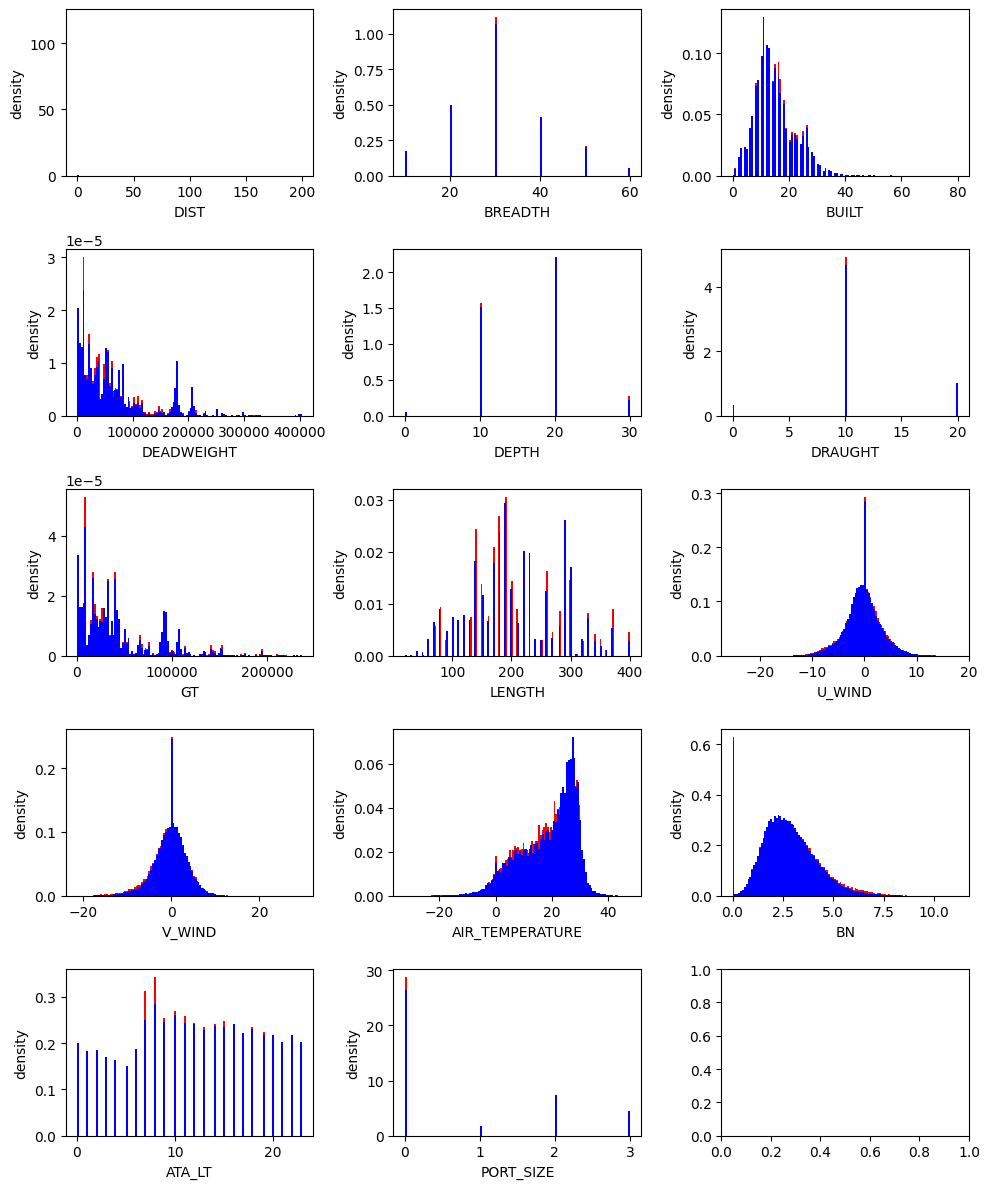

In [ ]:
# 대기시간이 0인 경우와 비교
zero_target_df = train[train['CI_HOUR'] == 0]

f, ax = plt.subplots(5,3, figsize=(10,12))
ax = ax.ravel()
for ax, f in zip(ax, ['DIST',
 'BREADTH',
 'BUILT',
 'DEADWEIGHT',
 'DEPTH',
 'DRAUGHT',
 'GT',
 'LENGTH',
 'U_WIND',
 'V_WIND',
 'AIR_TEMPERATURE',
 'BN',
 'ATA_LT',
 'PORT_SIZE']):
  ax.hist(zero_target_df[f], bins=120, density=True, color='red') #zero인 경우
  ax.hist(train[f], bins=120, density=True, color='blue')
  ax.set_xlabel(f)
  ax.set_ylabel('density')
plt.tight_layout()
plt.show()

**Insight**

- 대기시간이 0인 경우와 아닌 경우를 비교하면, LENGTH 변수에서 차이를 보임.

In [ ]:
from IPython.core.display import HTML
cat_cols = train.select_dtypes(include='object').columns.tolist()
def value_counts_all(df, columns):
    pd.set_option('display.max_rows',50)
    table_list=[]
    for col in columns:
        table_list.append(pd.DataFrame(df[col].value_counts()))
    return HTML(f"<table><tr> {''.join(['<td>'+table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

value_counts_all(train,cat_cols)

,ARI_CO
CN,141743
JP,52752
SG,43865
AU,32853
TW,32616
IN,16192
RU,14383
CA,10890
KR,10644
BR,9374


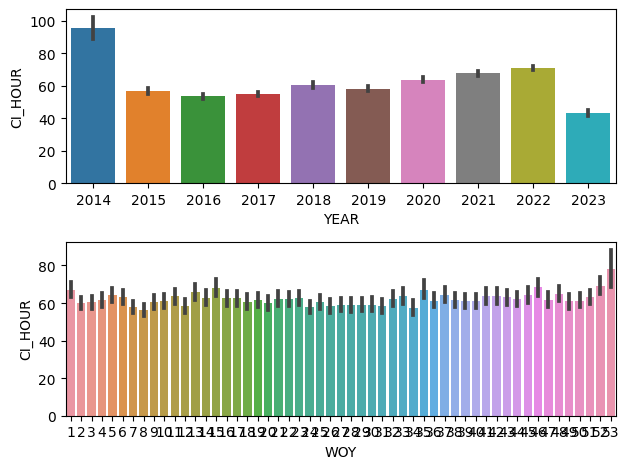

In [ ]:
plt.subplot(2,1,1)
sns.barplot(x=train['YEAR'], y=train['CI_HOUR'])
plt.subplot(2,1,2)
sns.barplot(x=train['WOY'], y=train['CI_HOUR']) #week of year
plt.tight_layout()

- QUARTER은 버려야함.

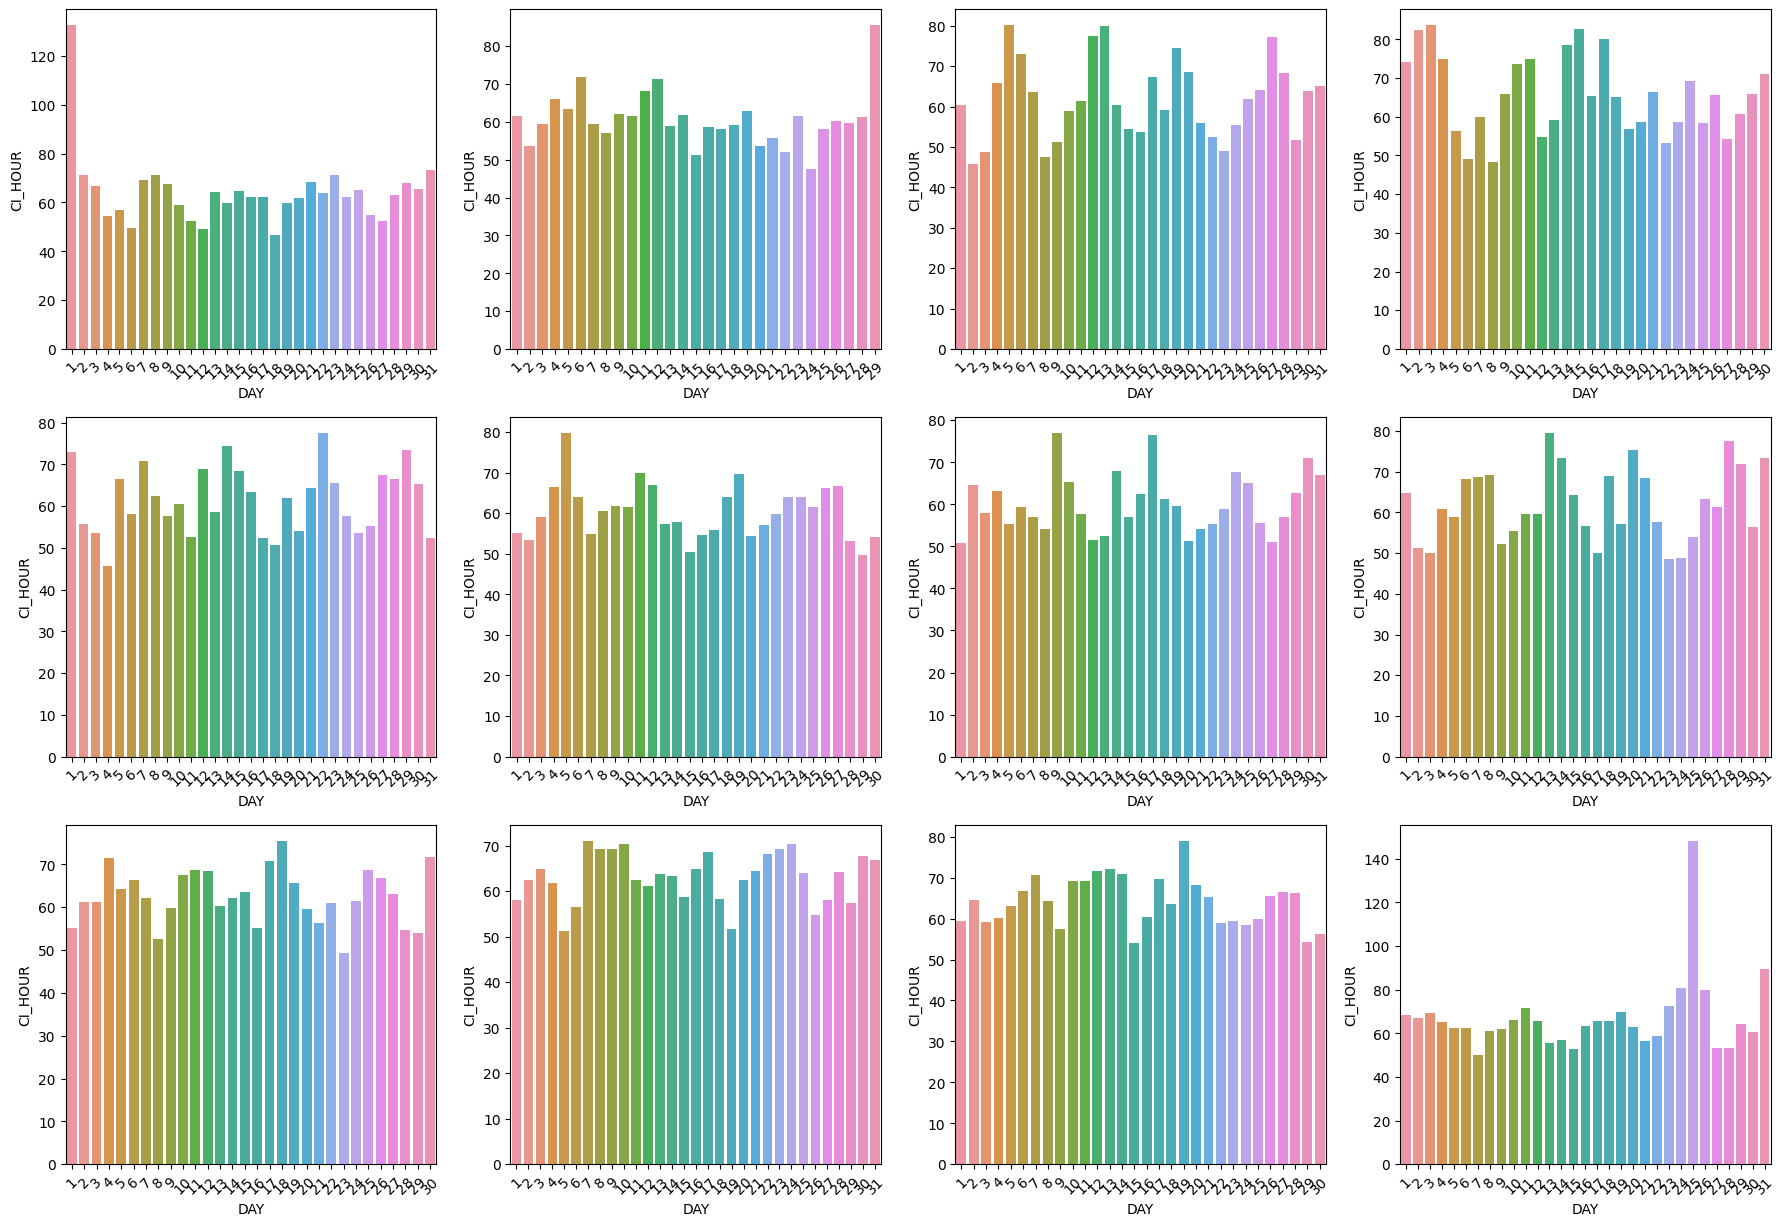

In [ ]:
#Christmas
i = 0
plt.subplots(2,6,figsize=(22,15))
for month in range(1,13):
  i += 1
  plt.subplot(3,4,i)
  _ = train[train['MONTH'] == month]
  sns.barplot(x=_['DAY'], y=_['CI_HOUR'], ci=None)
  plt.xticks(rotation=45)
plt.show()

- 일정한 간격으로 주기가 있어보임
  - isweekend 필요할 듯함.
- 비교적 높은 구간
  - 1월 1일 / 2월 29일 / 12월 25일

<Axes: >

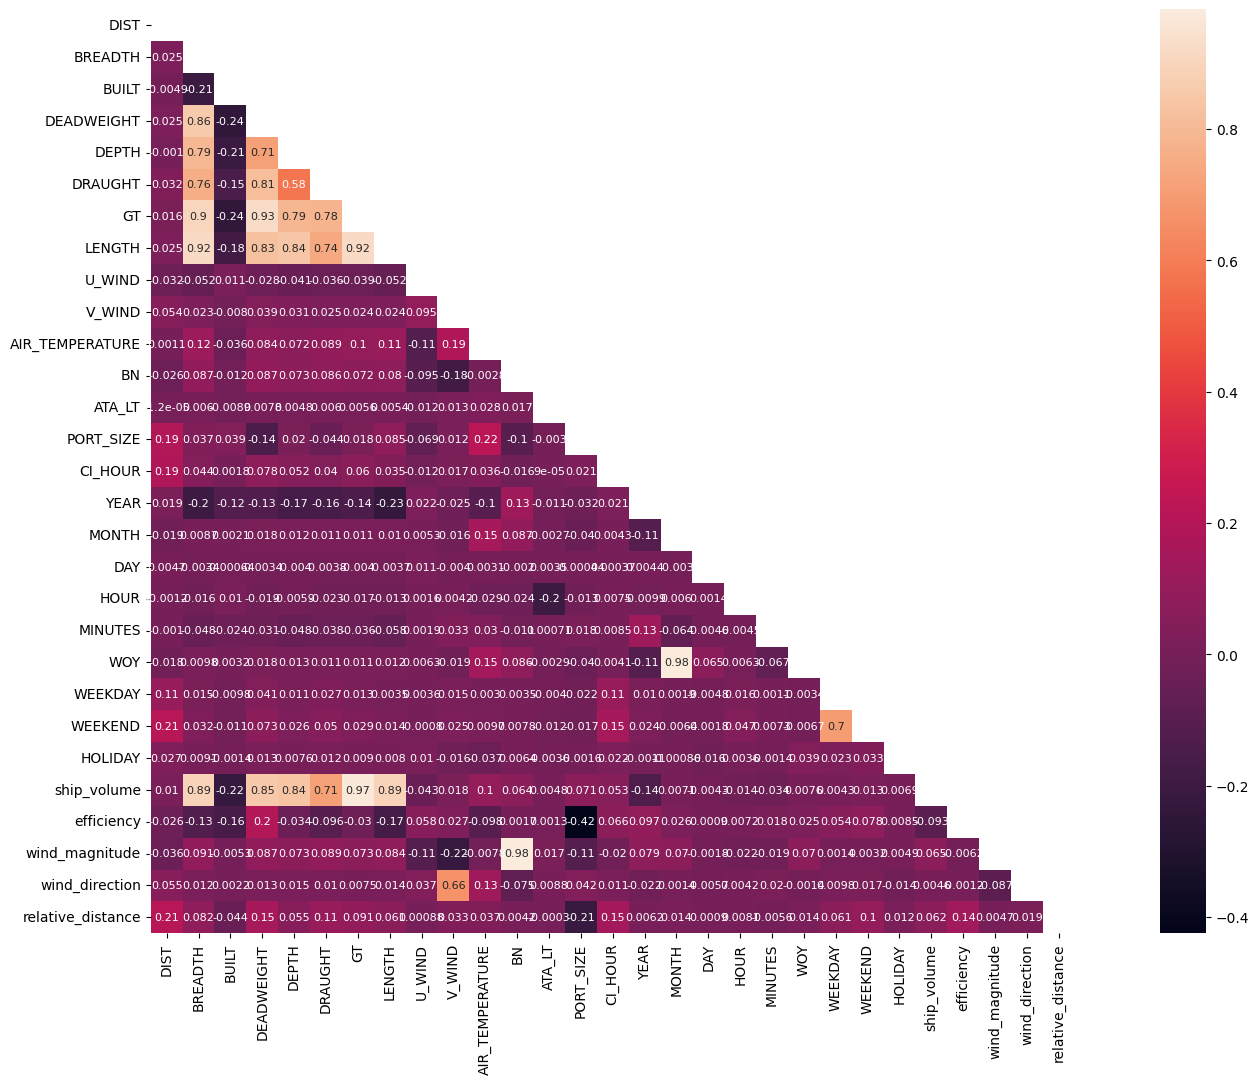

In [ ]:
plt.figure(figsize=(22,12))
mask = np.triu(train.corr())
sns.heatmap(train.corr(), square=True, mask=mask, annot=True, annot_kws={'fontsize':8})

In [ ]:
X.shape, test.shape

((391938, 21), (220491, 21))

# DUMMYMODEL

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2 ,random_state=42)

In [ ]:
X_train.shape, X_test.shape

((313550, 20), (78388, 20))

Dummy

In [ ]:
np.mean(y_train)

62.05100976007421

In [ ]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)

pred = dummy.predict(X_test)

dummy_score = mean_absolute_error(y_test, pred)

print(f"Mean score : {dummy_score}")

Mean score : 80.18567335896508


**Insight**

- MAE기준, 80이 최소 성능 기준이 됨.